In [ ]:
using QuantumAnnealingTools
# This package is needed to load actual ODE solvers. Without it, the ODE solvers won't work.
using OrdinaryDiffEq
# We need to plot our results for the demo
using Plots

# Single Qubit Example

In this example, we will try to recreate the example in this paper: [Decoherence in adiabatic quantum computation](https://arxiv.org/abs/1503.08767).
The Hamiltonian is
\begin{equation}
H(s) = -\frac{1}{2}(1-s)\sigma_x - \frac{1}{2}s\sigma_z
\end{equation}
The following code block construct this Hamiltonian

In [3]:
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2)

DenseHamiltonian with Complex{Float64}
with size: (2, 2)

This package directly interacts with `Plots.jl`. We can look at the spectrum of the Hamiltonian by directly plotting the object

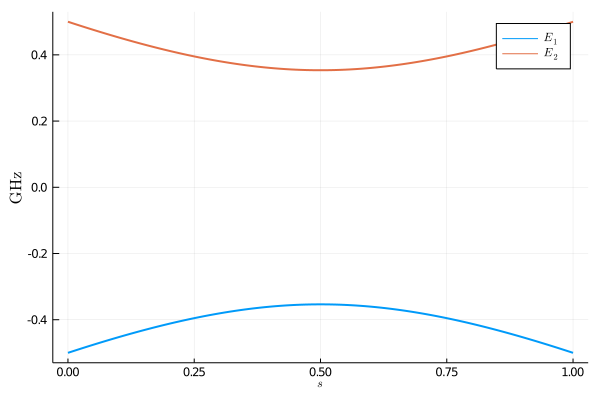

In [4]:
# this plot recipe is for conviniently plotting the spectrum of the Hamltonian
# the first 3 arguments are: the Hamiltonian, the grid `s` and the levels to keep
plot(H, 0:0.01:1, 2, linewidth=2)

## Unit ($h$ or $\hbar$)
There is a keyword argument `unit` for the constructor of any Hamiltonian object, whose default value is `:h`. This argument specifies the unit of other input arguments. For example, setting `unit` to `:h` means other input argument is in $\mathrm{GHz}$, while setting it to `:ħ` means the unit is in $2\pi\mathrm{GHz}$. To evaluate the value of Hamiltonian object at a given time, it is recommended to use `evaluate` function instead of directly calling the object. This will also return the value in the unit system of $h=1$.

In [7]:
H_h = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:h)
H_ħ = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:ħ)
println("Setting unit to :h")
@show evaluate(H_h, 0.5)
println("Setting unit to :ħ")
@show evaluate(H_ħ, 0.5);

Setting unit to :h
evaluate(H_h, 0.5) = Complex{Float64}[-0.25 + 0.0im -0.25 + 0.0im; -0.25 + 0.0im 0.25 + 0.0im]
Setting unit to :ħ
evaluate(H_ħ, 0.5) = Complex{Float64}[-0.039788735772973836 + 0.0im -0.039788735772973836 + 0.0im; -0.039788735772973836 + 0.0im 0.039788735772973836 + 0.0im]


Internally, this package use a unit system of $\hbar=1$. If we call `H_h` directly, we can see that the value is scaled by $2\pi$.

In [8]:
H_h(0.5)

2×2 StaticArrays.MArray{Tuple{2,2},Complex{Float64},2,4} with indices SOneTo(2)×SOneTo(2):
 -1.5708+0.0im  -1.5708+0.0im
 -1.5708+0.0im   1.5708+0.0im

## Annealing
The total Hamiltonian is
\begin{equation}
    H(s) = H_{\mathrm{S}}(s) + gS \otimes B + H_{\mathrm{B}}
\end{equation}
We denote $S$ the coupling and $\{gB, H_{\mathrm{B}}\}$ the bath.
### Coupling
For constant coupling operators, we can use constructor `ConstantCouplings`. Like the case of Hamiltonian, there will be a keyword argument `unit` to specify the input unit.

In [9]:
coupling = ConstantCouplings(["Z"])

ConstantCouplings with AbstractArray{T,2} where T
and string representation: ["Z"]

### Bath
A bath instance can be any object which implement three methods:
  1. Correlation function: `correlation(τ, bath)`
  2. Spectrum density: `γ(ω, bath)`
  3. Lamb shift: `S(ω, bath)`

Those three methods are required by Redfield/Adiabatic ME solvers. Currently we have built in support for Ohmic bath.
An Ohmic bath object can be created by

In [10]:
η = 1e-4
fc = 4
T = 16
bath = Ohmic(η, fc, T)

Ohmic bath instance:
η (unitless): 0.0001
ωc (GHz): 4.0
T (mK): 16.0

`info_freq` is a convenient function to convert each quantities into the same unit.

In [11]:
info_freq(bath)

ωc (GHz): 4.0
T (GHz): 0.33338579560200365


We can also directly plot the spectrum density of Ohmic bath

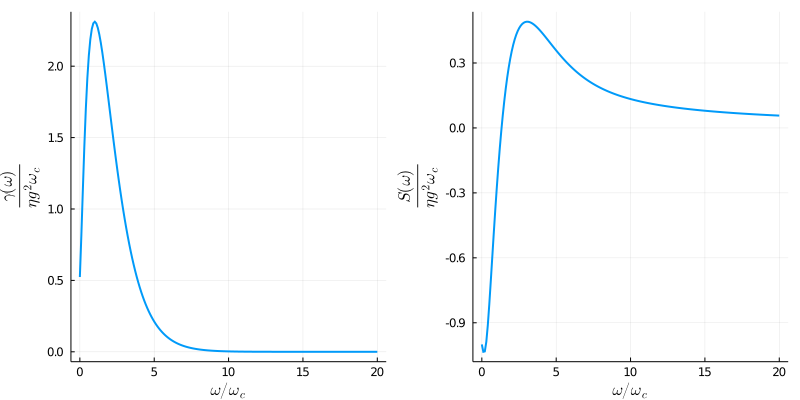

In [12]:
p1 = plot(bath, :γ, range(0,20,length=200), label="", size=(800, 400), linewidth=2)
p2 = plot(bath, :S, range(0,20,length=200), label="", size=(800, 400), linewidth=2)
plot(p1, p2, layout=(1,2), left_margin=3Plots.Measures.mm)

### Annealing

Finally, we can assemble the annealing object by

In [2]:
# Hamiltonian
H = DenseHamiltonian([(s)->1-s, (s)->s], -[σx, σz]/2, unit=:ħ)
# initial state
u0 = PauliVec[1][1]
# coupling
coupling = ConstantCouplings(["Z"], unit=:ħ)
# bath
bath = Ohmic(1e-4, 4, 16)
annealing = Annealing(H, u0; coupling=coupling, bath=bath)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
u0 with size: (2,)

Because we want to compare our results to the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320), we need to set the unit to $\hbar=1$.

## Solvers
Currently there are several interface to the solvers which might be handy. The first one is the solver for Schrodinger equation.

In [4]:
tf = 10*sqrt(2)
@time sol = solve_schrodinger(annealing, tf, alg=Tsit5(), retol=1e-4);

 11.045790 seconds (39.21 M allocations: 2.139 GiB, 7.05% gc time)


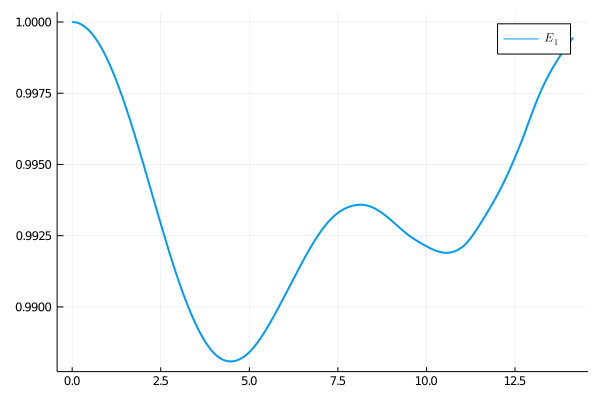

In [6]:
# a convinient plot recipe to plot the instantaneous population during the evolution
# currently only support Hamiltonian with annealing parameter s = t/tf from 0 to 1.
plot(sol, H, [1], 0:0.01:tf, linewidth=2)

The solution is an `ODESolution` object in `DifferentialEquations.jl` package. More details for the interface can be found [here](http://docs.juliadiffeq.org/latest/basics/solution.html). The value of state vector at a given time can be obtained by directly calling the `ODESolution` object.

In [7]:
sol(0.5)

2-element Array{Complex{Float64},1}:
 0.6856253144209079 + 0.1750041214939618im
 0.6861430138705714 + 0.1688172359560306im

other interface includes

In [9]:
# You need to solve the unitary first before trying to solve Redfield equation
@time U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-8, retol=1e-8);
@time solve_von_neumann(annealing, tf, alg=Tsit5(), abstol=1e-8, retol=1e-8);

  0.000298 seconds (1.68 k allocations: 95.203 KiB)
  0.000217 seconds (1.06 k allocations: 57.625 KiB)


### Open System
#### Time dependent Redfield equation
The time depedent Redfield equation interface needs
  1. Annealing object
  2. Total annealing time
  3. Pre-calculated unitary
  
All the other keyword arguments in [solver options](http://docs.juliadiffeq.org/latest/basics/common_solver_opts.html) are supported. Currently, support for implicit methods are only for `solve_schrodinger`.

In [10]:
tf = 10*sqrt(2)
U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-8, retol=1e-8);
sol = solve_redfield(annealing, tf, U; alg=Tsit5(), abstol=1e-8, retol=1e-8);

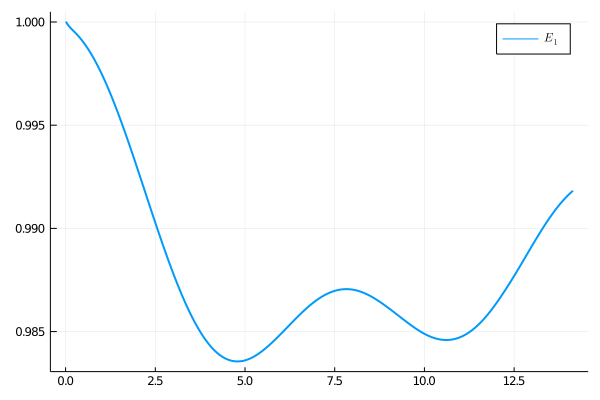

In [12]:
plot(sol, H, [1], 0:0.01:tf, linewidth=2)

#### Adiabatic master equation
The adiabatic master equation interface needs
  1. Annealing object
  2. Total Annealing time

Besides other keyword arguments supported in `DifferentialEquations`, it is highly recommended to add the `ω_hint` keyword argument. By doing this, the solver will pre-compute the lamb shift $S(\omega)$ within given range to speed up the computation.

In [13]:
tf = 10*sqrt(2)
@time sol = solve_ame(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-4);

  7.519835 seconds (26.41 M allocations: 1.292 GiB, 3.66% gc time)


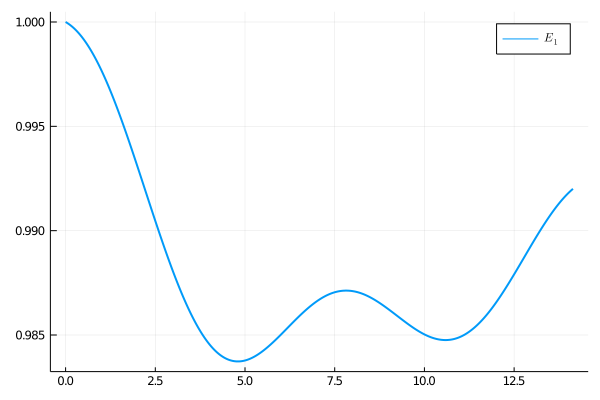

In [14]:
plot(sol, H, [1], 0:0.01:tf, linewidth=2)

In [7]:
tf = 5000
@time sol_ame = solve_ame(annealing, tf; alg=Tsit5(), ω_hint=range(-6, 6, length=100), reltol=1e-4);

 10.533062 seconds (45.42 M allocations: 2.280 GiB, 7.76% gc time)


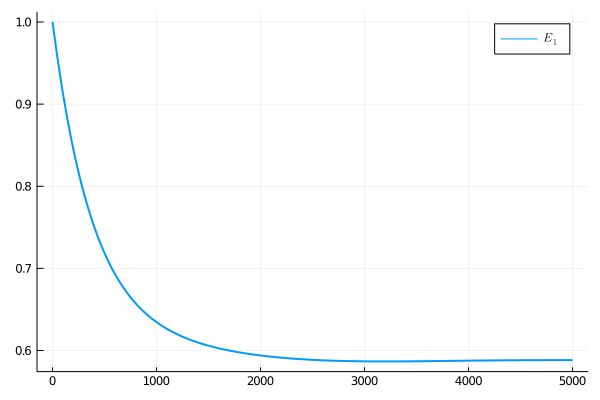

In [18]:
plot(sol_ame, H, [1], 0:1:tf, linewidth=2)

The above results agree with Fig 2 of the [reference paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.91.062320).

#### Trajectory method for adiabatic master equation
The package also supports the trajectory method for AME. More details of this method can be found in this [paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.022116). The basic workflow is to create ODE [EnsembleProblem](https://docs.juliadiffeq.org/dev/features/ensemble/) via `build_ensembles` interface. Then, the resulting ensemble problem can be solved by the native [Parallel Ensemble Simulations](https://docs.juliadiffeq.org/dev/features/ensemble/) interface of `DifferentialEquations.jl`. The following code block solves the same $t_f = 5000(ns)$ annealing above with 1000 trajectories.

In [5]:
tf = 5000
prob = build_ensembles(annealing, tf, :ame, ω_hint=range(-6, 6, length=100))
# to use multi-threads, you need to start Julia kernel with multiple threads
sol = solve(prob, Tsit5(), EnsembleThreads(), trajectories=1000, reltol=1e-4, saveat=range(0,1,length=100));

In [30]:
s_axis = range(0,tf,length=100)
dataset = []
for s in s_axis
    w, v = eigen_decomp(H, s/tf)
    push!(dataset, [abs2(normalize(so(s, continuity=:right))' * v[:, 1]) for so in sol])
end

pop_mean = []
pop_rmse = []
for data in dataset
    p_mean = sum(data)/1000
    p_rmse = sqrt(sum((x)->(x-p_mean)^2, data))/1000
    push!(pop_mean, p_mean)
    push!(pop_rmse, p_rmse)
end

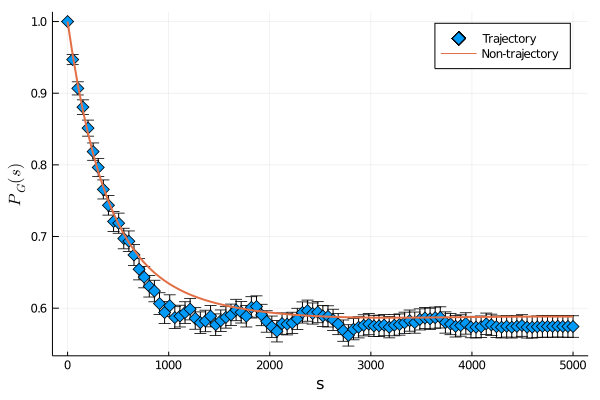

In [31]:
scatter(s_axis, pop_mean, marker=:d, yerror=pop_rmse, label="Trajectory", markersize=6)
plot!(sol_ame, H, [1], s_axis, linewidth=2, label="Non-trajectory")
xlabel!("s")
ylabel!("\$P_G(s)\$")